Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


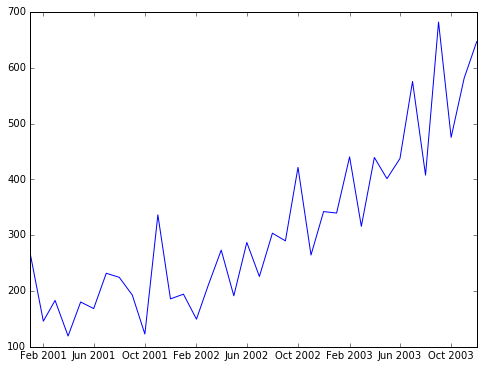

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(8, 6)

def parser(x):
    return pd.datetime.strptime('200'+x, '%Y-%m')


tseries = pd.read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print tseries.head()

plt.plot(tseries)


In [82]:
from statsmodels.tsa.stattools import adfuller 

def is_stationary(tseries):
    rolmean = tseries.rolling(window=4,center=False).mean() 
    rolstd = tseries.rolling(window=4,center=False).std()
    
    orig = plt.plot(tseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling Stdv')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    print 'Resulsts of Dickey-Fuller Test:'
    
    dftest = adfuller(tseries, autolag='AIC')
    dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# of Lags used', '# of Observation used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

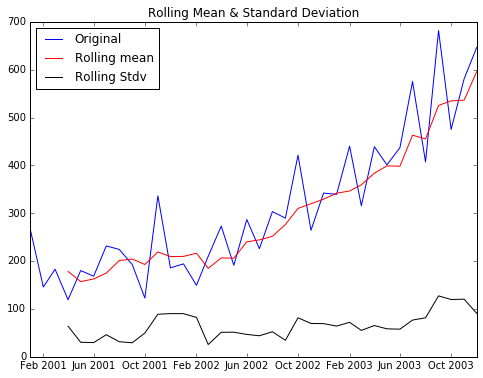

Resulsts of Dickey-Fuller Test:
Test Statistic            3.060142
p-value                   1.000000
# of Lags used           10.000000
# of Observation used    25.000000
Critical Value (5%)      -2.986489
Critical Value (1%)      -3.723863
Critical Value (10%)     -2.632800
dtype: float64


In [83]:
is_stationary(tseries)

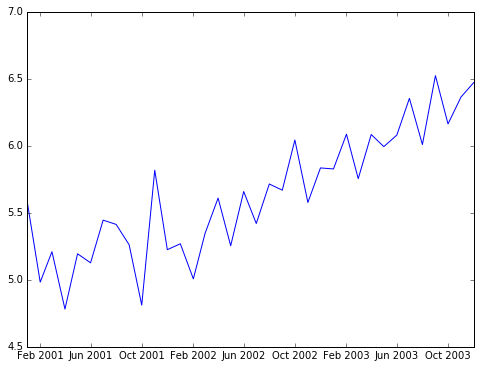

In [84]:
import numpy as np
ts_log = np.log(tseries)
plt.plot(ts_log)

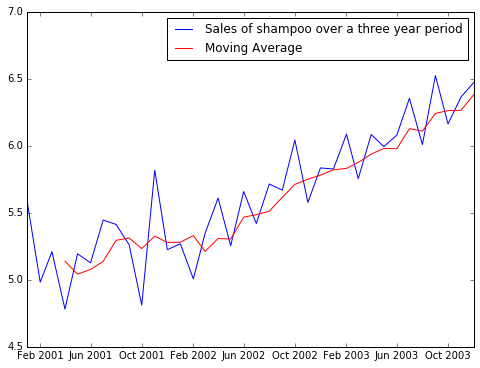

In [85]:
rol_avg = ts_log.rolling(window=4, center=False).mean()
plt.plot(ts_log)
plt.plot(rol_avg, color='red', label='Moving Average')
plt.legend(loc='best')

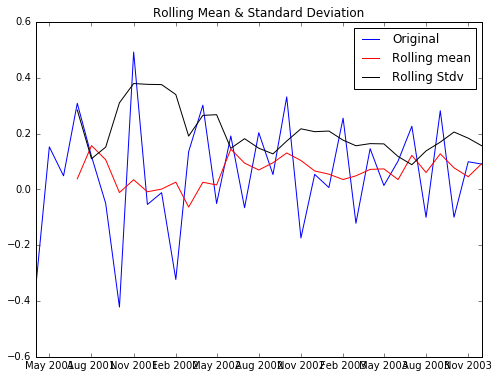

Resulsts of Dickey-Fuller Test:
Test Statistic           -2.732263
p-value                   0.068620
# of Lags used           10.000000
# of Observation used    22.000000
Critical Value (5%)      -3.005426
Critical Value (1%)      -3.769733
Critical Value (10%)     -2.642501
dtype: float64


In [86]:
ts_log_rol_avg_diff = ts_log - rol_avg
ts_log_rol_avg_diff.dropna(inplace=True)
is_stationary(ts_log_rol_avg_diff)

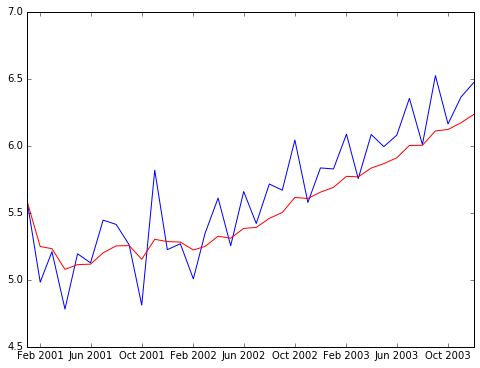

In [68]:
expWMA = ts_log.ewm(halflife = 3).mean()
plt.plot(ts_log)
plt.plot(expWMA, color='red')

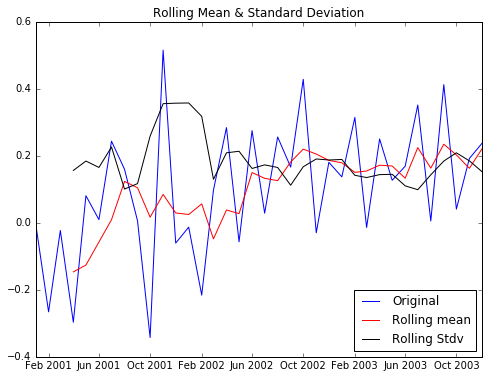

Resulsts of Dickey-Fuller Test:
Test Statistic           -2.485870
p-value                   0.118950
# of Lags used           10.000000
# of Observation used    25.000000
Critical Value (5%)      -2.986489
Critical Value (1%)      -3.723863
Critical Value (10%)     -2.632800
dtype: float64


In [69]:
ts_log_ewma_diff = ts_log - expWMA
is_stationary(ts_log_ewma_diff)

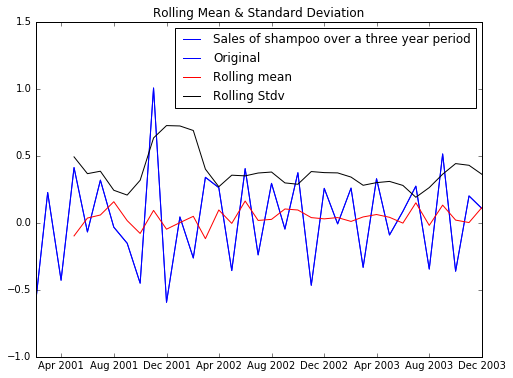

Resulsts of Dickey-Fuller Test:
Test Statistic           -2.168202
p-value                   0.217988
# of Lags used           10.000000
# of Observation used    24.000000
Critical Value (5%)      -2.992216
Critical Value (1%)      -3.737709
Critical Value (10%)     -2.635747
dtype: float64


In [70]:
ts_log_diff = ts_log - ts_log.shift()

plt.plot(ts_log_diff)

ts_log_diff.dropna(inplace=True)
is_stationary(ts_log_diff)

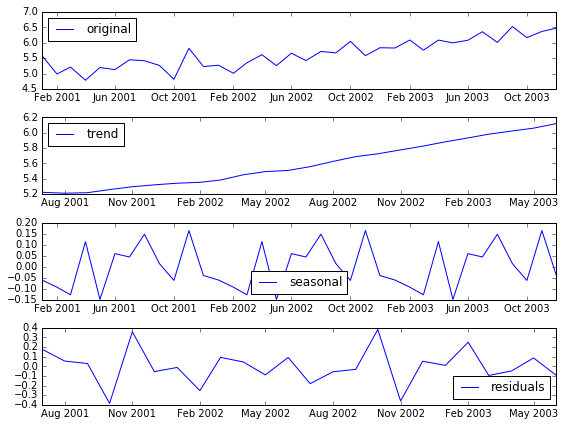

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='residuals')
plt.legend(loc='best')

plt.tight_layout()

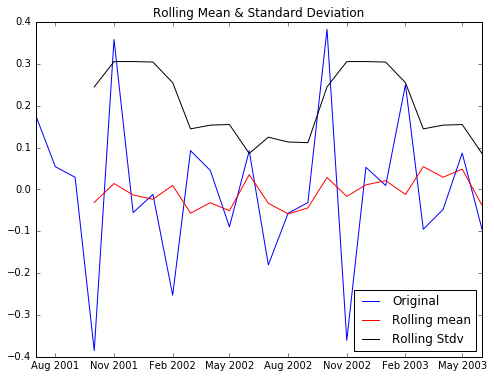

Resulsts of Dickey-Fuller Test:
Test Statistic           -1.344175
p-value                   0.608728
# of Lags used            9.000000
# of Observation used    14.000000
Critical Value (5%)      -3.104184
Critical Value (1%)      -4.012034
Critical Value (10%)     -2.690987
dtype: float64


In [72]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
is_stationary(ts_log_decompose)

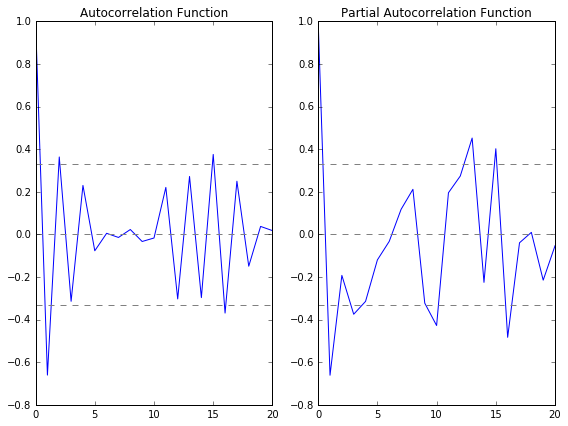

In [73]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


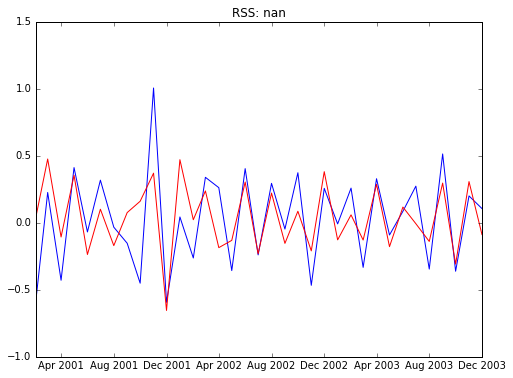

In [74]:
#AR Model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log)**2))



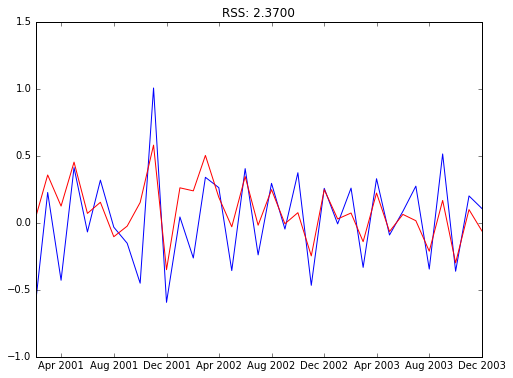

In [75]:
#MA Model

model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

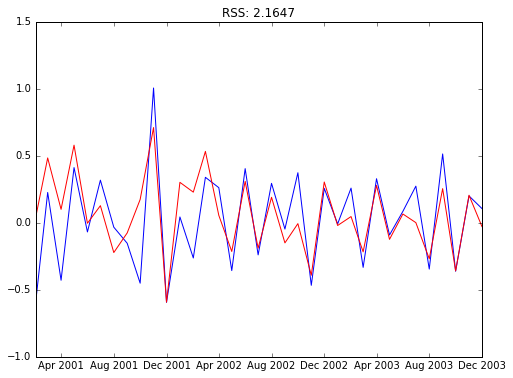

In [76]:
## Combined Model
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))



In [77]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
2001-02-01    0.037293
2001-03-01    0.484970
2001-04-01    0.101135
2001-05-01    0.580283
2001-06-01   -0.002748
dtype: float64


In [78]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
2001-02-01    0.037293
2001-03-01    0.522263
2001-04-01    0.623399
2001-05-01    1.203682
2001-06-01    1.200934
dtype: float64


In [79]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
2001-01-01    5.583496
2001-02-01    5.620790
2001-03-01    6.105760
2001-04-01    6.206895
2001-05-01    6.787178
dtype: float64

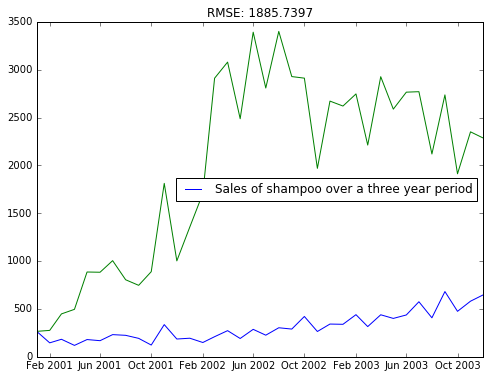

In [80]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(tseries)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-tseries)**2)/len(tseries)))
plt.legend(loc='best')

In [59]:
from pandas.tools.plotting import autocorrelation_plot

In [60]:
#autocorrelation_plot(tseries)
#plt.show()

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Wed, 13 Sep 2017   AIC                            406.340
Time:                                                 21:38:58   BIC                            417.227
Sample:                                             02-01-2001   HQIC                           410.098
                                                  - 12-01-2003                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

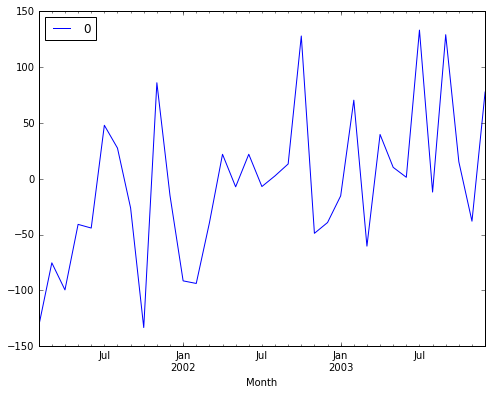

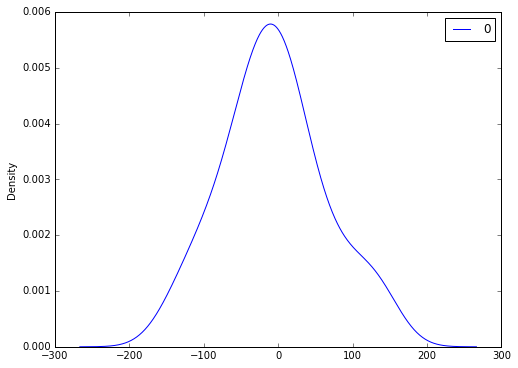

                0
count   35.000000
mean    -5.495209
std     68.132882
min   -133.296608
25%    -42.477894
50%     -7.186564
75%     24.748349
max    133.237976


In [61]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(tseries, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())